#### Objetivo y propuesta
El objetivo de este trabajo es predecir el diagnóstico de un tumor mamario (benigno o maligno) utilizando un conjunto de características extraıdas de imágenes microscópicas digitalizadas de muestras
tumorales. Estas caracterısticas describen la forma, tamaño, textura y otras propiedades morfologicas
de los nucleos celulares, permitiendo entrenar modelos de aprendizaje automático capaces de distinguir entre lesiones benignas y malignas.
 ##### 1. Realizar un análisis exploratorio de los datos (EDA) que incluya:
Estadísticas descriptivas de las variables del dataset.
Visualizaciones básicas que permitan comprender la distribución de las variables.

##### 2. Definir las métricas de evaluación que se emplearán para comparar los modelos. Además de
describirlas, se debe justificar su elección en el contexto del problema, considerando aspectos
clínicos, implicancias de falsos positivos y falsos negativos, etc.

 ##### 3. Aplicar al menos cinco modelos de clasificación, entre los cuales pueden incluirse:
Regresión logística
Linear Discriminant Analysis (LDA)
Quadratic Discriminant Analysis (QDA)
K-Nearest Neighbors (KNN)
Random Forest
Otros algoritmos supervisados apropiados
##### 4. A partir de los resultados que se obtienen, se deben seleccionar los dos mejores algoritmos y documentar detalladamente el procedimiento realizado de manera que permita al lector reproducir
el trabajo en su totalidad, incluyendo
Variables utilizadas
Par´ametros empleados en cada algoritmo
Funciones y librerías utilizadas
Cualquier paso de preprocesamiento

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.decomposition import PCA


/home/santiago/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, ttest_ind, mannwhitneyu

def tabla1(df, group_var):
    """
    Produce una tabla resumen de variables continuas para dos grupos definidos
    por 'group_var'. Evalúa normalidad con skew y kurtosis (no usa Shapiro).
    """

    # Obtener los niveles reales del factor (ej: [0,1] o ["benigno","maligno"])
    levels = df[group_var].dropna().unique()
    if len(levels) != 2:
        raise ValueError("La variable de grupo debe tener exactamente dos niveles.")
    gA, gB = levels[0], levels[1]

    resultados = []

    # Variables continuas (todas excepto la binaria)
    vars_cont = df.drop(columns=[group_var]).columns

    for var in vars_cont:
        x = df[var]
        xA = df[df[group_var] == gA][var]
        xB = df[df[group_var] == gB][var]

        # Estadísticos descriptivos
        desc = {
            "variable": var,
            "n_missing": x.isna().sum(),
            "mean": x.mean(),
            "sd": x.std(),
            "min": x.min(),
            "q25": x.quantile(0.25),
            "median": x.median(),
            "q75": x.quantile(0.75),
            "max": x.max(),
            "skew": skew(x.dropna()),
            "kurtosis": kurtosis(x.dropna(), fisher=True),
            f"mean_{gA}": xA.mean(),
            f"median_{gA}": xA.median(),
            f"mean_{gB}": xB.mean(),
            f"median_{gB}": xB.median()
        }

        # Decidir test paramétrico vs no paramétrico
        skew_abs = abs(desc["skew"])
        kurt_abs = abs(desc["kurtosis"])

        if skew_abs < 1 and kurt_abs < 1:  
            # aproximación normal razonable
            stat, pval = ttest_ind(xA, xB, nan_policy="omit", equal_var=False)
        else:
            stat, pval = mannwhitneyu(xA, xB, alternative="two-sided")

        desc["p_value"] = pval
        resultados.append(desc)

    return pd.DataFrame(resultados)




def plot_corr_matrix(df, figsize=(10, 8), cmap="coolwarm"):
    """
    Grafico elegante de matriz de correlación para variables numéricas.
    """

    # Seleccionar solo columnas numéricas
    num_df = df.select_dtypes(include=[np.number])
    corr = num_df.corr()

    # Crear máscara para el triángulo superior
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Estilo
    sns.set_theme(style="white")

    # Figura
    plt.figure(figsize=figsize)

    # Heatmap
    ax = sns.heatmap(
        corr,
        mask=mask,
        annot=True,          # muestra correlaciones en la celda
        fmt=".2f",
        cmap=cmap,
        square=True,
        linewidths=.5,
        cbar_kws={"shrink": .8}
    )

    # Rotar labels para legibilidad
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.title("Matriz de Correlación", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    


def panel_violin_box(df, group=None, figsize=(18, 12)):
    """
    df: dataframe solo con variables continuas
    group: nombre de la columna categórica binaria para comparar (opcional)
    """
    variables = df.columns if group is None else df.drop(columns=[group]).columns
    n_vars = len(variables)

    # cantidad de filas y columnas para el panel
    n_cols = 5
    n_rows = int(np.ceil(n_vars / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    sns.set_style("whitegrid")
    sns.set_palette("Set2")

    for ax, var in zip(axes, variables):
        if group is None:
            # un solo grupo
            sns.violinplot(y=df[var], ax=ax, inner=None)
            sns.boxplot(y=df[var], ax=ax, width=0.2, showcaps=True,
                        boxprops={'zorder': 2}, whiskerprops={'zorder': 2})
        else:
            # dividido por grupo
            sns.violinplot(x=df[group], y=df[var], ax=ax, inner=None)
            sns.boxplot(x=df[group], y=df[var], ax=ax, width=0.2, showcaps=True,
                        boxprops={'zorder': 2}, whiskerprops={'zorder': 2})

        ax.set_title(var, fontsize=11)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # eliminar paneles vacíos
    for j in range(n_vars, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [4]:
data = pd.read_csv("data.csv")
X = data[data.columns[:-1]]
y = [1 if i=='M' else 0 for i in data.target]

La Tabla 1 sintetiza, para cada variable continua del estudio, un conjunto amplio de estadísticas descriptivas y elementos inferenciales destinados a caracterizar su comportamiento y evaluar diferencias entre los dos grupos definidos por la variable binaria de referencia. En primer lugar, se reportan medidas clásicas de tendencia central y dispersión (media, desviación estándar y mediana), junto con los valores mínimo y máximo y los cuartiles 1 y 3, lo cual permite examinar tanto la localización como la variabilidad y el grado de concentración de las observaciones. Adicionalmente, se incluyen medidas de forma —asimetría (skewness) y curtosis— que proporcionan información sobre la simetría y el grado de apuntamiento de la distribución empírica, y que en este análisis cumplen un rol metodológico adicional: sirven como criterio operativo para decidir la conveniencia de emplear métodos inferenciales paramétricos o no paramétricos al comparar grupos.

Complementariamente, la tabla presenta las medias y medianas calculadas por separado para cada uno de los dos grupos, lo cual permite apreciar de manera directa y cuantitativa la magnitud de las diferencias observadas, independientemente del resultado del contraste formal. Finalmente, para cada variable se informa el valor p del test de hipótesis correspondiente: si la distribución presenta asimetría y curtosis dentro de un rango compatible con aproximación a la normalidad, se aplica una prueba t para muestras independientes con varianzas no necesariamente homogéneas; de lo contrario, se emplea el test no paramétrico de Mann–Whitney, basado en rangos.

Los resultados exhiben un patrón extremadamente consistente tanto en la comparación de medidas de tendencia central como en los contrastes estadísticos: prácticamente la totalidad de las variables muestran diferencias sustanciales entre ambos grupos, con valores p que en muchos casos se ubican por debajo de 10⁻³⁰ e incluso 10⁻⁶⁰, lo que evidencia un rechazo contundente de la hipótesis nula de igualdad entre distribuciones.

Desde un punto de vista descriptivo, todas las variables vinculadas a tamaño y escala morfométrica, tales como radius, perimeter y area en sus versiones mean, se y worst, exhiben valores claramente superiores en el grupo M respecto del grupo B. Las diferencias en media son amplias (a menudo duplicando los valores del grupo B) y las medianas muestran el mismo patrón, lo que indica que la separación entre grupos no depende únicamente de valores extremos sino de diferencias estructurales efectivas en la distribución. Estas variables presentan, además, asimetrías positivas y curtosis marcadamente elevadas, lo que revela distribuciones con colas largas hacia la derecha. La magnitud de la asimetría —por ejemplo, area_se con skew > 5— y de la curtosis —por ejemplo, concavity_se con valores cercanos a 50— justifica plenamente la elección de contrastes no paramétricos en la mayoría de los casos.

Las variables asociadas a irregularidad o complejidad geométrica (compactness, concavity, concave points) muestran algunas de las diferencias más pronunciadas entre grupos, especialmente en sus versiones worst. Las medias del grupo M suelen duplicar o triplicar las del grupo B, reforzando la idea de que las lesiones del grupo M exhiben mayor irregularidad estructural. Al igual que en las variables morfométricas, estas características presentan distribuciones altamente sesgadas y leptocúrticas, lo que vuelve inapropiada la suposición de normalidad y robustece la necesidad de utilizar tests no paramétricos.

En cuanto a las variables relacionadas con textura (texture_mean, texture_worst) y dimensiones fractales, también se encuentran diferencias significativas, aunque de menor magnitud absoluta. Sin embargo, incluso en estas variables, las diferencias de medias y medianas entre M y B permanecen alineadas y los valores p son extremadamente bajos. La única excepción clara es fractal_dimension_mean, cuyo valor p (≈0.54) indica ausencia de evidencia para diferencias entre grupos. Asimismo, texture_se y smoothness_se presentan valores p moderados (alrededor de 0.64 y 0.21, respectivamente), lo que sugiere que estas características específicas no contribuyen de manera sustancial a la discriminación entre grupos.

Es relevante destacar que en esta tabla no se observan datos faltantes (todas las variables tienen n_missing = 0), lo que elimina fuentes potenciales de sesgo por imputación o pérdida de información. Este aspecto facilita la interpretación directa de los estadísticos descriptivos y de los contrastes.

En síntesis, la Tabla 1 muestra un patrón global robusto:

las diferencias entre grupos son grandes, sistemáticas y unidireccionales;

la estructura de las distribuciones está lejos de la normalidad en la mayoría de los casos, con altos niveles de asimetría y curtosis;

los contrastes inferenciales confirman dicho patrón con valores p extremadamente bajos; y

solo un número muy reducido de variables (tres, en total) no exhibe diferencias estadísticamente relevantes.

En conjunto, estos resultados no solo documentan la existencia de diferencias claras entre los grupos, sino que además ofrecen una caracterización multivariada precisa que respalda análisis posteriores tales como modelos discriminantes, regresiones multivariadas o técnicas de clasificación supervisada.

In [5]:
tabla_uno = tabla1(data, "target")

In [6]:
tabla_uno

,variable,n_missing,mean,sd,min,q25,median,q75,max,skew,kurtosis,mean_M,median_M,mean_B,median_B,p_value
0,radius_mean,0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000,0.939893,0.827584,17.462830,17.325000,12.146524,12.200000,1.684459e-64
1,texture_mean,0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000,0.648734,0.741145,21.604906,21.460000,17.914762,17.390000,3.019055e-25
2,perimeter_mean,0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000,0.988037,0.953165,115.365377,114.200000,78.075406,78.180000,1.023141e-66
3,area_mean,0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000,1.641391,3.609761,978.376415,932.000000,462.790196,458.400000,1.539780e-68
4,smoothness_mean,0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340,0.455120,0.837945,0.102898,0.102200,0.092478,0.090760,5.573331e-19
5,compactness_mean,0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540,1.186983,1.625140,0.145188,0.132350,0.080085,0.075290,8.951992e-48
6,concavity_mean,0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680,1.397483,1.970592,0.160775,0.151350,0.046058,0.037090,2.164549e-68
7,concave_mean,0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120,1.168090,1.046680,0.087990,0.086280,0.025717,0.023440,1.006324e-76
8,symmetry_mean,0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400,0.723695,1.266117,0.192909,0.189900,0.174186,0.171400,2.268050e-15
9,fractal_dimension_mean,0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744,1.301047,2.969017,0.062680,0.061575,0.062867,0.061540,5.371856e-01


In [7]:
tabla_uno.to_csv("tabla1.csv", index = False)

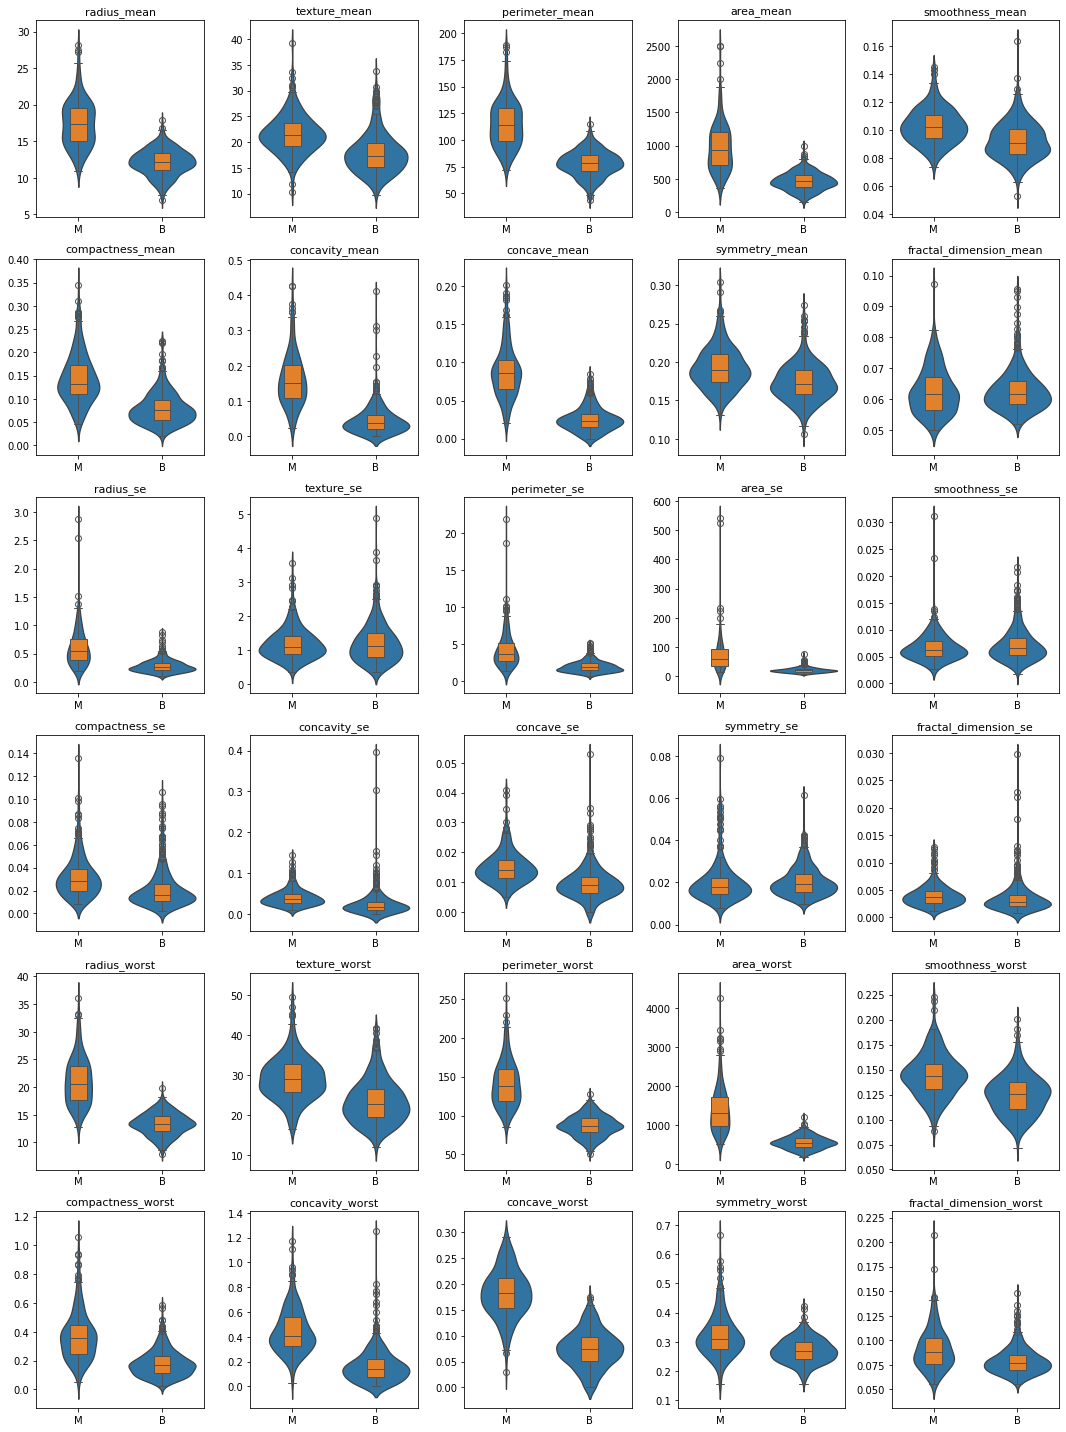

In [8]:
panel_violin_box(data, "target", figsize=(15,20))

In [12]:
# Matriz de correlación sin la última columna
corr = data[data.columns[:-1]].corr()

# Pasar a formato largo
corr_long = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # triángulo superior sin diagonal
        .stack()  # convertir a pares
        .reindex()  # asegurar orden
        .rename("corr")
        .sort_values(ascending=False)
)

print("Top 10 correlaciones absolutas:")
print(corr_long.tail(5))

Top 10 correlaciones absolutas:
fractal_dimension_mean  area_worst               -0.231854
                        radius_worst             -0.253691
perimeter_mean          fractal_dimension_mean   -0.261477
area_mean               fractal_dimension_mean   -0.283110
radius_mean             fractal_dimension_mean   -0.311631
Name: corr, dtype: float64


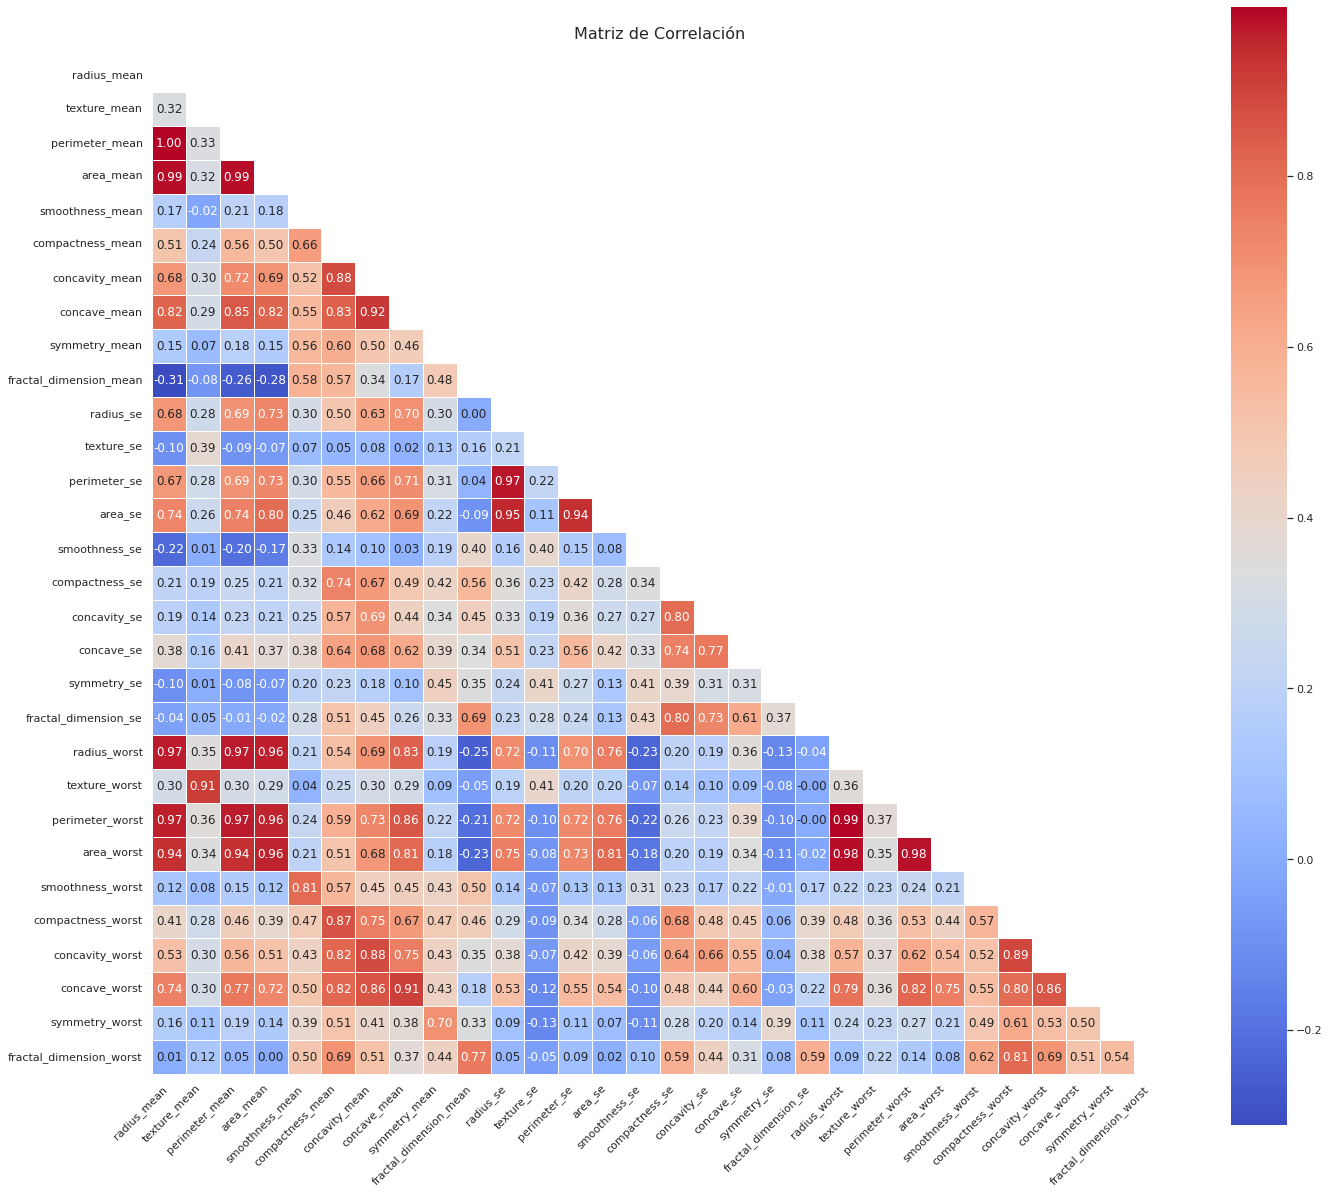

In [13]:
plot_corr_matrix(data, figsize=(20,20))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,   
    random_state=42,  
    stratify=y        
)

In [15]:
beta = 3   

fbeta = make_scorer(fbeta_score, beta=beta)

In [52]:
np.logspace(-4, 2, 10)

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [16]:
models = {
    "Logistic_L1": {
        "pipe": Pipeline([
            ("scale", StandardScaler()),
            ("clf", LogisticRegression(penalty='l1', solver='liblinear'))
        ]),
        "params": {
            "clf__C": np.logspace(-4, 2, 10),   # inverse of lambda
        }
    },

    "LDA": {
        "pipe": Pipeline([
            ("scale", StandardScaler()),
            ("clf", LinearDiscriminantAnalysis())
        ]),
        "params": {
            "clf__tol": [1e-4, 1e-3, 1e-2]
        }
    },


"QDA": {
    "pipe": Pipeline([
        ("scale", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("clf", QuadraticDiscriminantAnalysis())
    ]),
    "params": {
        "pca__n_components": [0.9, 0.95, 0.99],
        "clf__reg_param": [0, 0.01, 0.1, 0.5]
    }
}
,

    "KNN": {
        "pipe": Pipeline([
            ("scale", StandardScaler()),
            ("clf", KNeighborsClassifier())
        ]),
        "params": {
            "clf__n_neighbors": [3, 5, 7, 9, 11],
            "clf__weights": ["uniform", "distance"]
        }
    },

"RandomForest": {
    "pipe": Pipeline([
        ("clf", RandomForestClassifier())
    ]),
    "params": {
        # Número de árboles
        "clf__n_estimators": [200, 400, 800],

        # Profundidad del árbol
        "clf__max_depth": [None, 5, 10, 20, 40],

        # Mínimo de muestras para dividir un nodo
        "clf__min_samples_split": [2, 5, 10, 20],

        # Mínimo de muestras para ser una hoja
        "clf__min_samples_leaf": [1, 2, 4, 8],

        # ¿Se hace bootstrap o no?
        "clf__bootstrap": [True, False],

        # Tamaño de la muestra bootstrap (si bootstrap=True)
        "clf__max_samples": [None, 0.5, 0.7, 0.9],

        # Selección aleatoria de features por nodo
        # (clave para combatir colinealidad)
        "clf__max_features": ["sqrt", "log2", 0.5, 0.7, None],

        # Criterio de impureza
        "clf__criterion": ["gini", "entropy", "log_loss"]
    }
}

}


In [17]:
results = {}

for name, mp in models.items():
    print(f"\n=== Training {name} ===")

    grid = GridSearchCV(
        estimator=mp["pipe"],
        param_grid=mp["params"],
        scoring=fbeta,
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    results[name] = grid
    print(f"Best F-beta CV score: {grid.best_score_:.4f}")
    print(f"Best params: {grid.best_params_}")



=== Training Logistic_L1 ===
Best F-beta CV score: 0.9505
Best params: {'clf__C': 0.01}

=== Training LDA ===
Best F-beta CV score: 0.8775
Best params: {'clf__tol': 0.0001}

=== Training QDA ===
Best F-beta CV score: 0.9515
Best params: {'clf__reg_param': 0.01, 'pca__n_components': 0.99}

=== Training KNN ===
Best F-beta CV score: 0.9373
Best params: {'clf__n_neighbors': 3, 'clf__weights': 'uniform'}

=== Training RandomForest ===
Best F-beta CV score: 0.9410
Best params: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': 20, 'clf__max_features': 'sqrt', 'clf__max_samples': 0.9, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


In [25]:
# Ordenar modelos por puntaje de CV (de mayor a menor)
sorted_models = sorted(results.items(), key=lambda x: x[1].best_score_, reverse=True)

best_model_name, best_model_obj = sorted_models[0]      # el mejor (QDA)
second_model_name, second_model_obj = sorted_models[1]  # el segundo mejor (Logística L1)

best_model = best_model_obj.best_estimator_
best_model_2 = second_model_obj.best_estimator_

print("Best model:", best_model_name)
print(best_model)

print("\nSecond best model:", second_model_name)
print(best_model_2)


Best model: QDA
Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('clf', QuadraticDiscriminantAnalysis(reg_param=0.01))])

Second best model: Logistic_L1
Pipeline(steps=[('scale', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.01, penalty='l1', solver='liblinear'))])


In [42]:
from sklearn.base import clone

final_model = clone(best_model_obj.best_estimator_)
final_model.fit(X_train, y_train)

final_model_2 = clone(second_model_obj.best_estimator_)
final_model_2.fit(X_train, y_train)


,steps,"[('scale', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.01


In [43]:
y_pred = final_model.predict(X_test)

print("\n=== Test Set Performance ===")
print(classification_report(
    y_test, y_pred, digits=5,
    target_names=["Class 0", "Class 1"]
))



=== Test Set Performance ===
              precision    recall  f1-score   support

     Class 0    0.96296   0.96296   0.96296        54
     Class 1    0.93750   0.93750   0.93750        32

    accuracy                        0.95349        86
   macro avg    0.95023   0.95023   0.95023        86
weighted avg    0.95349   0.95349   0.95349        86



In [44]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[52  2]
 [ 2 30]]


In [45]:
log_reg = final_model_2.named_steps['clf']   # si ese es tu segundo mejor modelo
coef = log_reg.coef_[0]

n_coef_cero = (coef == 0).sum()
n_coef_no_cero = (coef != 0).sum()

print("Coeficientes en cero:", n_coef_cero)
print("Coeficientes distintos de cero:", n_coef_no_cero)


Coeficientes en cero: 27
Coeficientes distintos de cero: 3


In [39]:
dict(zip(X_train.columns, log_reg.coef_[0]))

{'radius_mean': 0.0,
 'texture_mean': 0.0,
 'perimeter_mean': 0.0,
 'area_mean': 0.0,
 'smoothness_mean': 0.0,
 'compactness_mean': 0.0,
 'concavity_mean': 0.0,
 'concave_mean': 0.0,
 'symmetry_mean': 0.0,
 'fractal_dimension_mean': 0.0,
 'radius_se': 0.0,
 'texture_se': 0.0,
 'perimeter_se': 0.0,
 'area_se': 0.0,
 'smoothness_se': 0.0,
 'compactness_se': 0.0,
 'concavity_se': 0.0,
 'concave_se': 0.0,
 'symmetry_se': 0.0,
 'fractal_dimension_se': 0.0,
 'radius_worst': 0.1341022130827152,
 'texture_worst': 0.0,
 'perimeter_worst': 0.32190906984990386,
 'area_worst': 0.0,
 'smoothness_worst': 0.0,
 'compactness_worst': 0.0,
 'concavity_worst': 0.0,
 'concave_worst': 0.41058328677043465,
 'symmetry_worst': 0.0,
 'fractal_dimension_worst': 0.0}

In [46]:
y_pred = final_model_2.predict(X_test)

print("\n=== Test Set Performance ===")
print(classification_report(
    y_test, y_pred, digits=5,
    target_names=["Class 0", "Class 1"]
))



=== Test Set Performance ===
              precision    recall  f1-score   support

     Class 0    1.00000   0.98148   0.99065        54
     Class 1    0.96970   1.00000   0.98462        32

    accuracy                        0.98837        86
   macro avg    0.98485   0.99074   0.98763        86
weighted avg    0.98872   0.98837   0.98841        86



In [47]:
print(confusion_matrix(y_test, y_pred))

[[53  1]
 [ 0 32]]


In [48]:
final_model_2

,steps,"[('scale', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.01


In [53]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, accuracy_score,
    f1_score, fbeta_score, roc_auc_score
)
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, beta=3, title=None):
    """
    Evalúa un modelo con matriz de confusión y métricas completas.
    
    Parameters
    ----------
    model : sklearn estimator
        Modelo previamente entrenado.
    X_test : array-like
        Matriz de features del set de prueba.
    y_test : array-like
        Etiquetas verdaderas.
    beta : float (default=3)
        Parámetro beta para el F-beta score.
    title : str (default=None)
        Título opcional para la matriz de confusión.
    """
    
    # === Predicciones ===
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidad clase positiva
    
    # === Matriz de Confusión ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title(title if title else "Confusion Matrix")
    plt.show()
    
    # === Métricas ===
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "F3-score": fbeta_score(y_test, y_pred, beta=beta),
        "AUC": roc_auc_score(y_test, y_prob)
    }

    print("\n=== Test Metrics ===")
    for m, v in metrics.items():
        print(f"{m:10}: {v:.4f}")
    
    return metrics


In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, accuracy_score,
    f1_score, fbeta_score, roc_auc_score,
    roc_curve, precision_recall_curve
)

def plot_full_evaluation(model, X_test, y_test, beta=3, title="Model Evaluation"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "F3-score": fbeta_score(y_test, y_pred, beta=beta),
        "AUC-ROC": roc_auc_score(y_test, y_prob),
    }

    # ROC & PR
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    prec, rec, _ = precision_recall_curve(y_test, y_prob)

    # Create multi-panel figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)

    # Panel 1 — Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0, 0], colorbar=False)
    axs[0, 0].set_title("Confusion Matrix")

    # Panel 2 — Metrics Table Rendered as Text
    axs[0, 1].axis("off")
    text_str = "\n".join([f"{k}: {v:.4f}" for k, v in metrics.items()])
    axs[0, 1].text(0.1, 0.5, text_str, fontsize=25, verticalalignment="center")
    axs[0, 1].set_title("Test Metrics")

    # Panel 3 — ROC Curve
    axs[1, 0].plot(fpr, tpr)
    axs[1, 0].plot([0, 1], [0, 1], linestyle="--")
    axs[1, 0].set_title("ROC Curve")
    axs[1, 0].set_xlabel("False Positive Rate")
    axs[1, 0].set_ylabel("True Positive Rate")

    # Panel 4 — Precision–Recall Curve
    axs[1, 1].plot(rec, prec)
    axs[1, 1].set_title("Precision–Recall Curve")
    axs[1, 1].set_xlabel("Recall")
    axs[1, 1].set_ylabel("Precision")

    plt.tight_layout()
    plt.show()

    return metrics


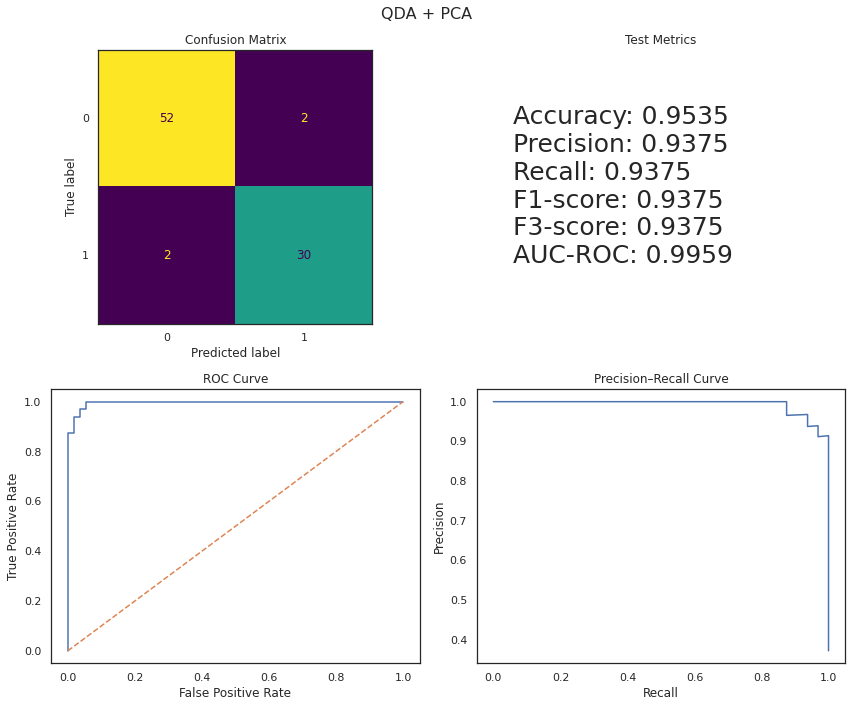

In [64]:
metrics_qda = plot_full_evaluation(best_model, X_test, y_test, title="QDA + PCA")


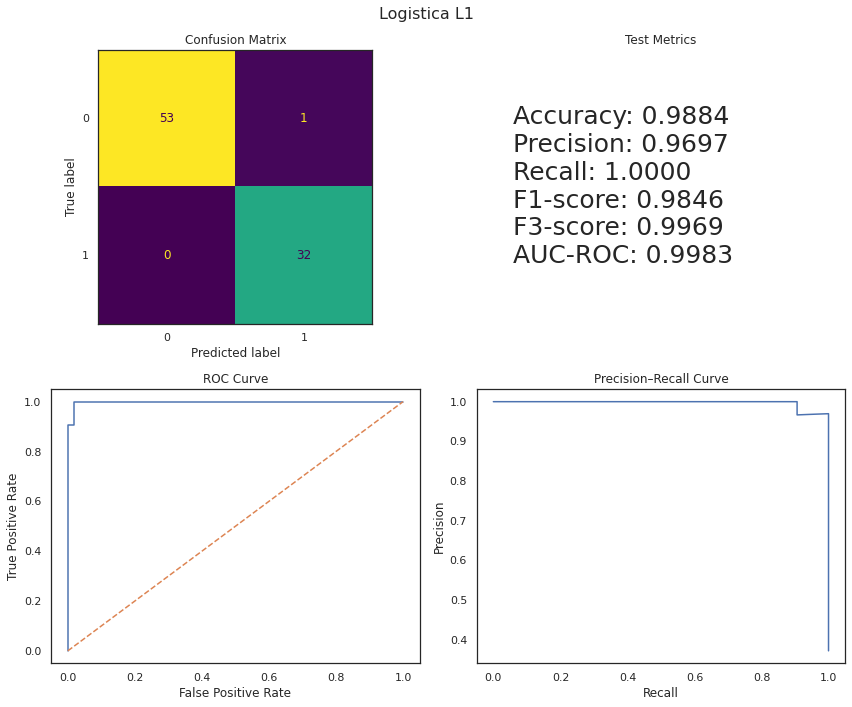

In [65]:
metrics_logist = plot_full_evaluation(best_model_2, X_test, y_test, title="Logistica L1")


In [66]:
best_model_2

,steps,"[('scale', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.01
